In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dropout,Dense,Activation,BatchNormalization,Input

2.14.0


### Load data

In [3]:
data = np.load('public_data.npz', allow_pickle=True)

# Extract the image dataset and labels
data_array = data['data']
labels_array = data['labels']

index_to_remove = [58, 338]
# Initializes a list to save image indices equal to the reference_image
matching_indices = []

for x in index_to_remove:
  # Reference image (x position)
  reference_image = data_array[x]

  # Loop through the images in the dataset
  for i, image in enumerate(data_array):
      if np.array_equal(image, reference_image):
          matching_indices.append(i)
# Remove the elements and their labels present in matching_indexes
data_array = np.delete(data_array, matching_indices, axis=0)
labels_array = np.delete(labels_array, matching_indices, axis=0)

print("Shape of data:", data_array.shape)
print("Shape of labels:", labels_array.shape)

print('\nExample of data:')
print(labels_array[0])

Shape of data: (5004, 96, 96, 3)
Shape of labels: (5004,)

Example of data:
healthy


In [4]:
data_array = data_array.astype('float32')

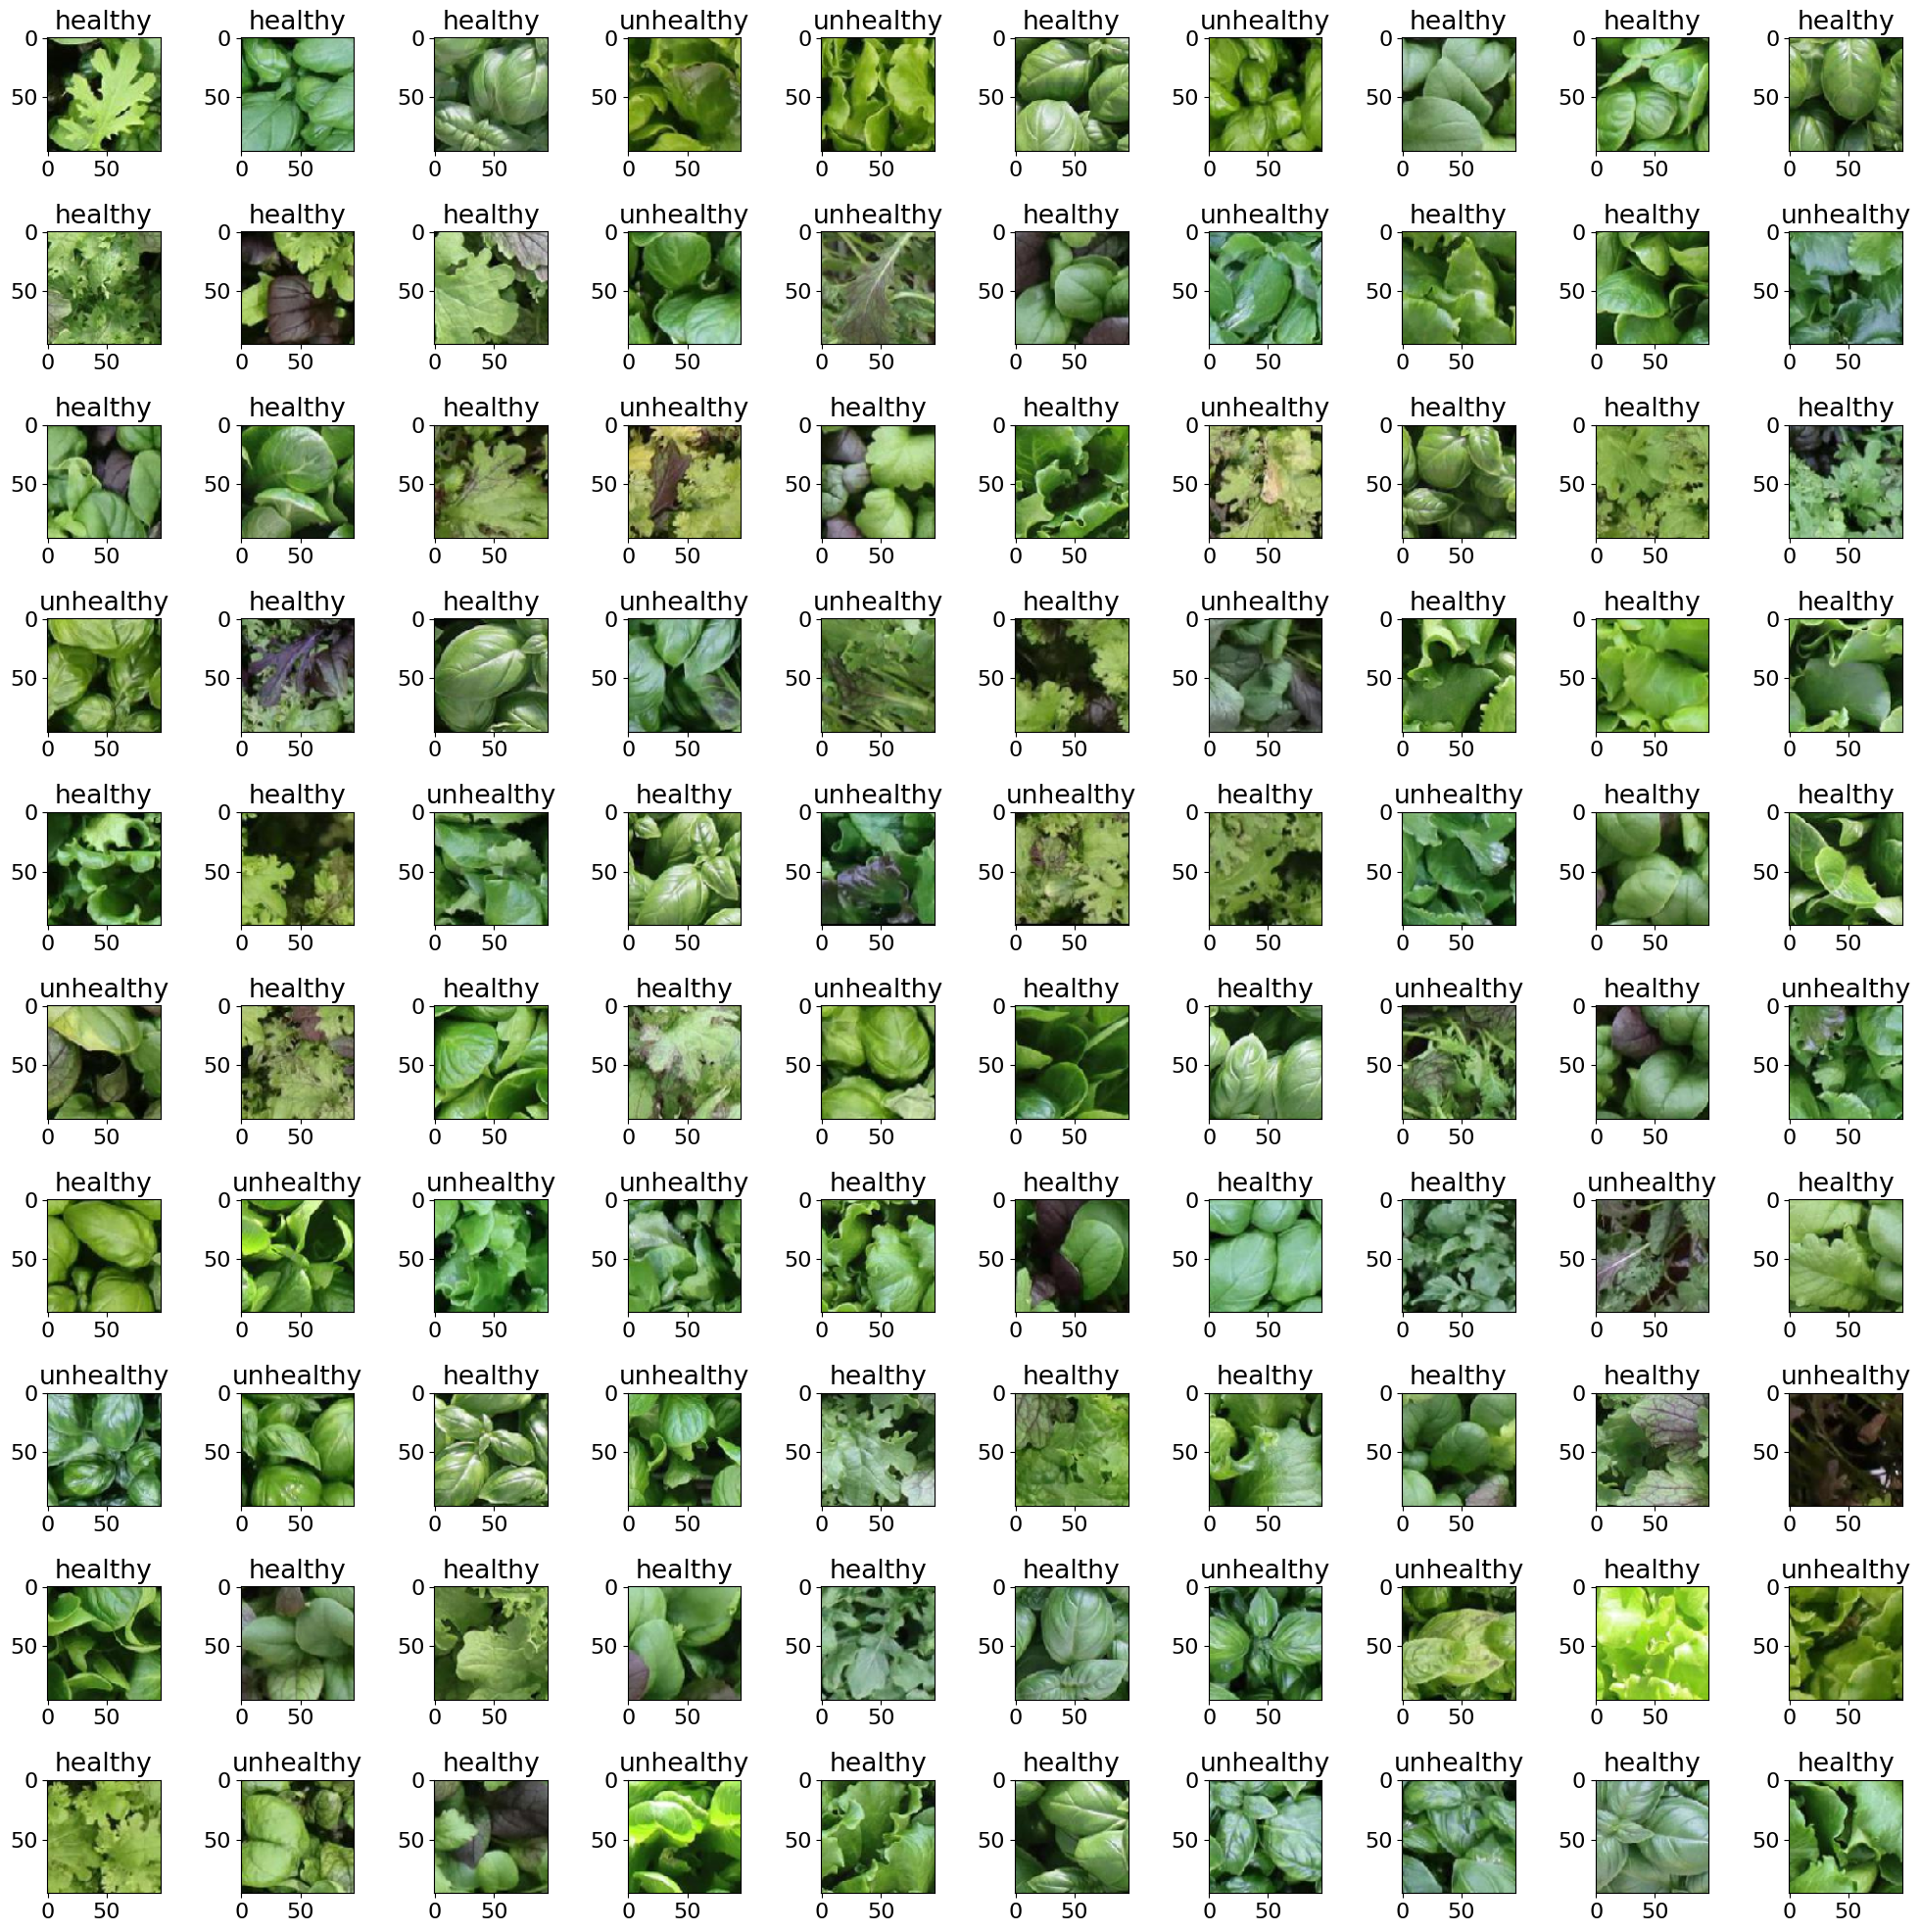

In [5]:
# Display a sample of images from the training-validation dataset
num_img = 100
num_rows = 10  # Number of rows (total images / 10 columns)
num_cols = 10  # Number of columns (10 images per row)

start = 0
end = 100

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Iterate through the selected number of images and print labels for debugging
for i in range(start, end):
    ax = axes[(i - start) // num_cols, (i - start) % num_cols]
    ax.imshow(data_array[i] / 255, cmap='gray')
    label = labels_array[i]
    ax.set_title('{}'.format(label))

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [6]:
# split in X_train, y_train and X_val, y_val
X_val, X_test, y_val, y_test = train_test_split(data_array, labels_array, test_size=0.20, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_val, y_val, test_size=0.20, random_state=42, shuffle=True)

# Print the shapes of the loaded datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)

print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (3202, 96, 96, 3)
Training Label Shape: (3202,)
Validation Data Shape: (801, 96, 96, 3)
Validation Label Shape: (801,)
Test Data Shape: (1001, 96, 96, 3)
Test Label Shape: (1001,)


In [7]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator for the training dataset
aug_data_gen = ImageDataGenerator(
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.4, 1.6),
    rotation_range=40,
    fill_mode='reflect'
)

In [8]:
aug_data_gen.fit(X_train)

augmented_images = []
augmented_labels = []

# Generate augmented images and append them to the list
for img_batch, lab_batch in aug_data_gen.flow(X_train, y_train, batch_size=1):
    for img, lab in zip(img_batch, lab_batch):
        augmented_images.append(img)
        augmented_labels.append(lab)

    if len(augmented_images) >= len(X_train) * 3:
        break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate the original training dataset with the augmented images
combined_images = np.concatenate((data_array, augmented_images))
combined_labels = np.concatenate((labels_array, augmented_labels))
np.savez('combined_train_data.npz',data=combined_images,labels=combined_labels)

In [9]:
# Image augmentation for validation dataset
aug_data_gen = ImageDataGenerator(
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.4, 1.6),
    rotation_range=40,
    fill_mode='reflect'
)

In [10]:
aug_data_gen.fit(X_val)

augmented_images = []
augmented_labels = []

# Generate augmented images and append them to the list
for img_batch, lab_batch in aug_data_gen.flow(X_val, y_val, batch_size=1):
    for img, lab in zip(img_batch, lab_batch):
        augmented_images.append(img)
        augmented_labels.append(lab)

    if len(augmented_images) >= len(X_val) * 3:
        break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate the original validation dataset with the augmented images
combined_images = np.concatenate((data_array, augmented_images))
combined_labels = np.concatenate((labels_array, augmented_labels))
np.savez('combined_val_data.npz',data=combined_images,labels=combined_labels)

In [11]:
data = np.load('combined_train_data.npz', allow_pickle=True)

# Extract the image dataset and labels
X_train = data['data']
y_train = data['labels']

In [12]:
data = np.load('combined_val_data.npz', allow_pickle=True)

# Extract the image dataset and labels
X_val = data['data']
y_val = data['labels']

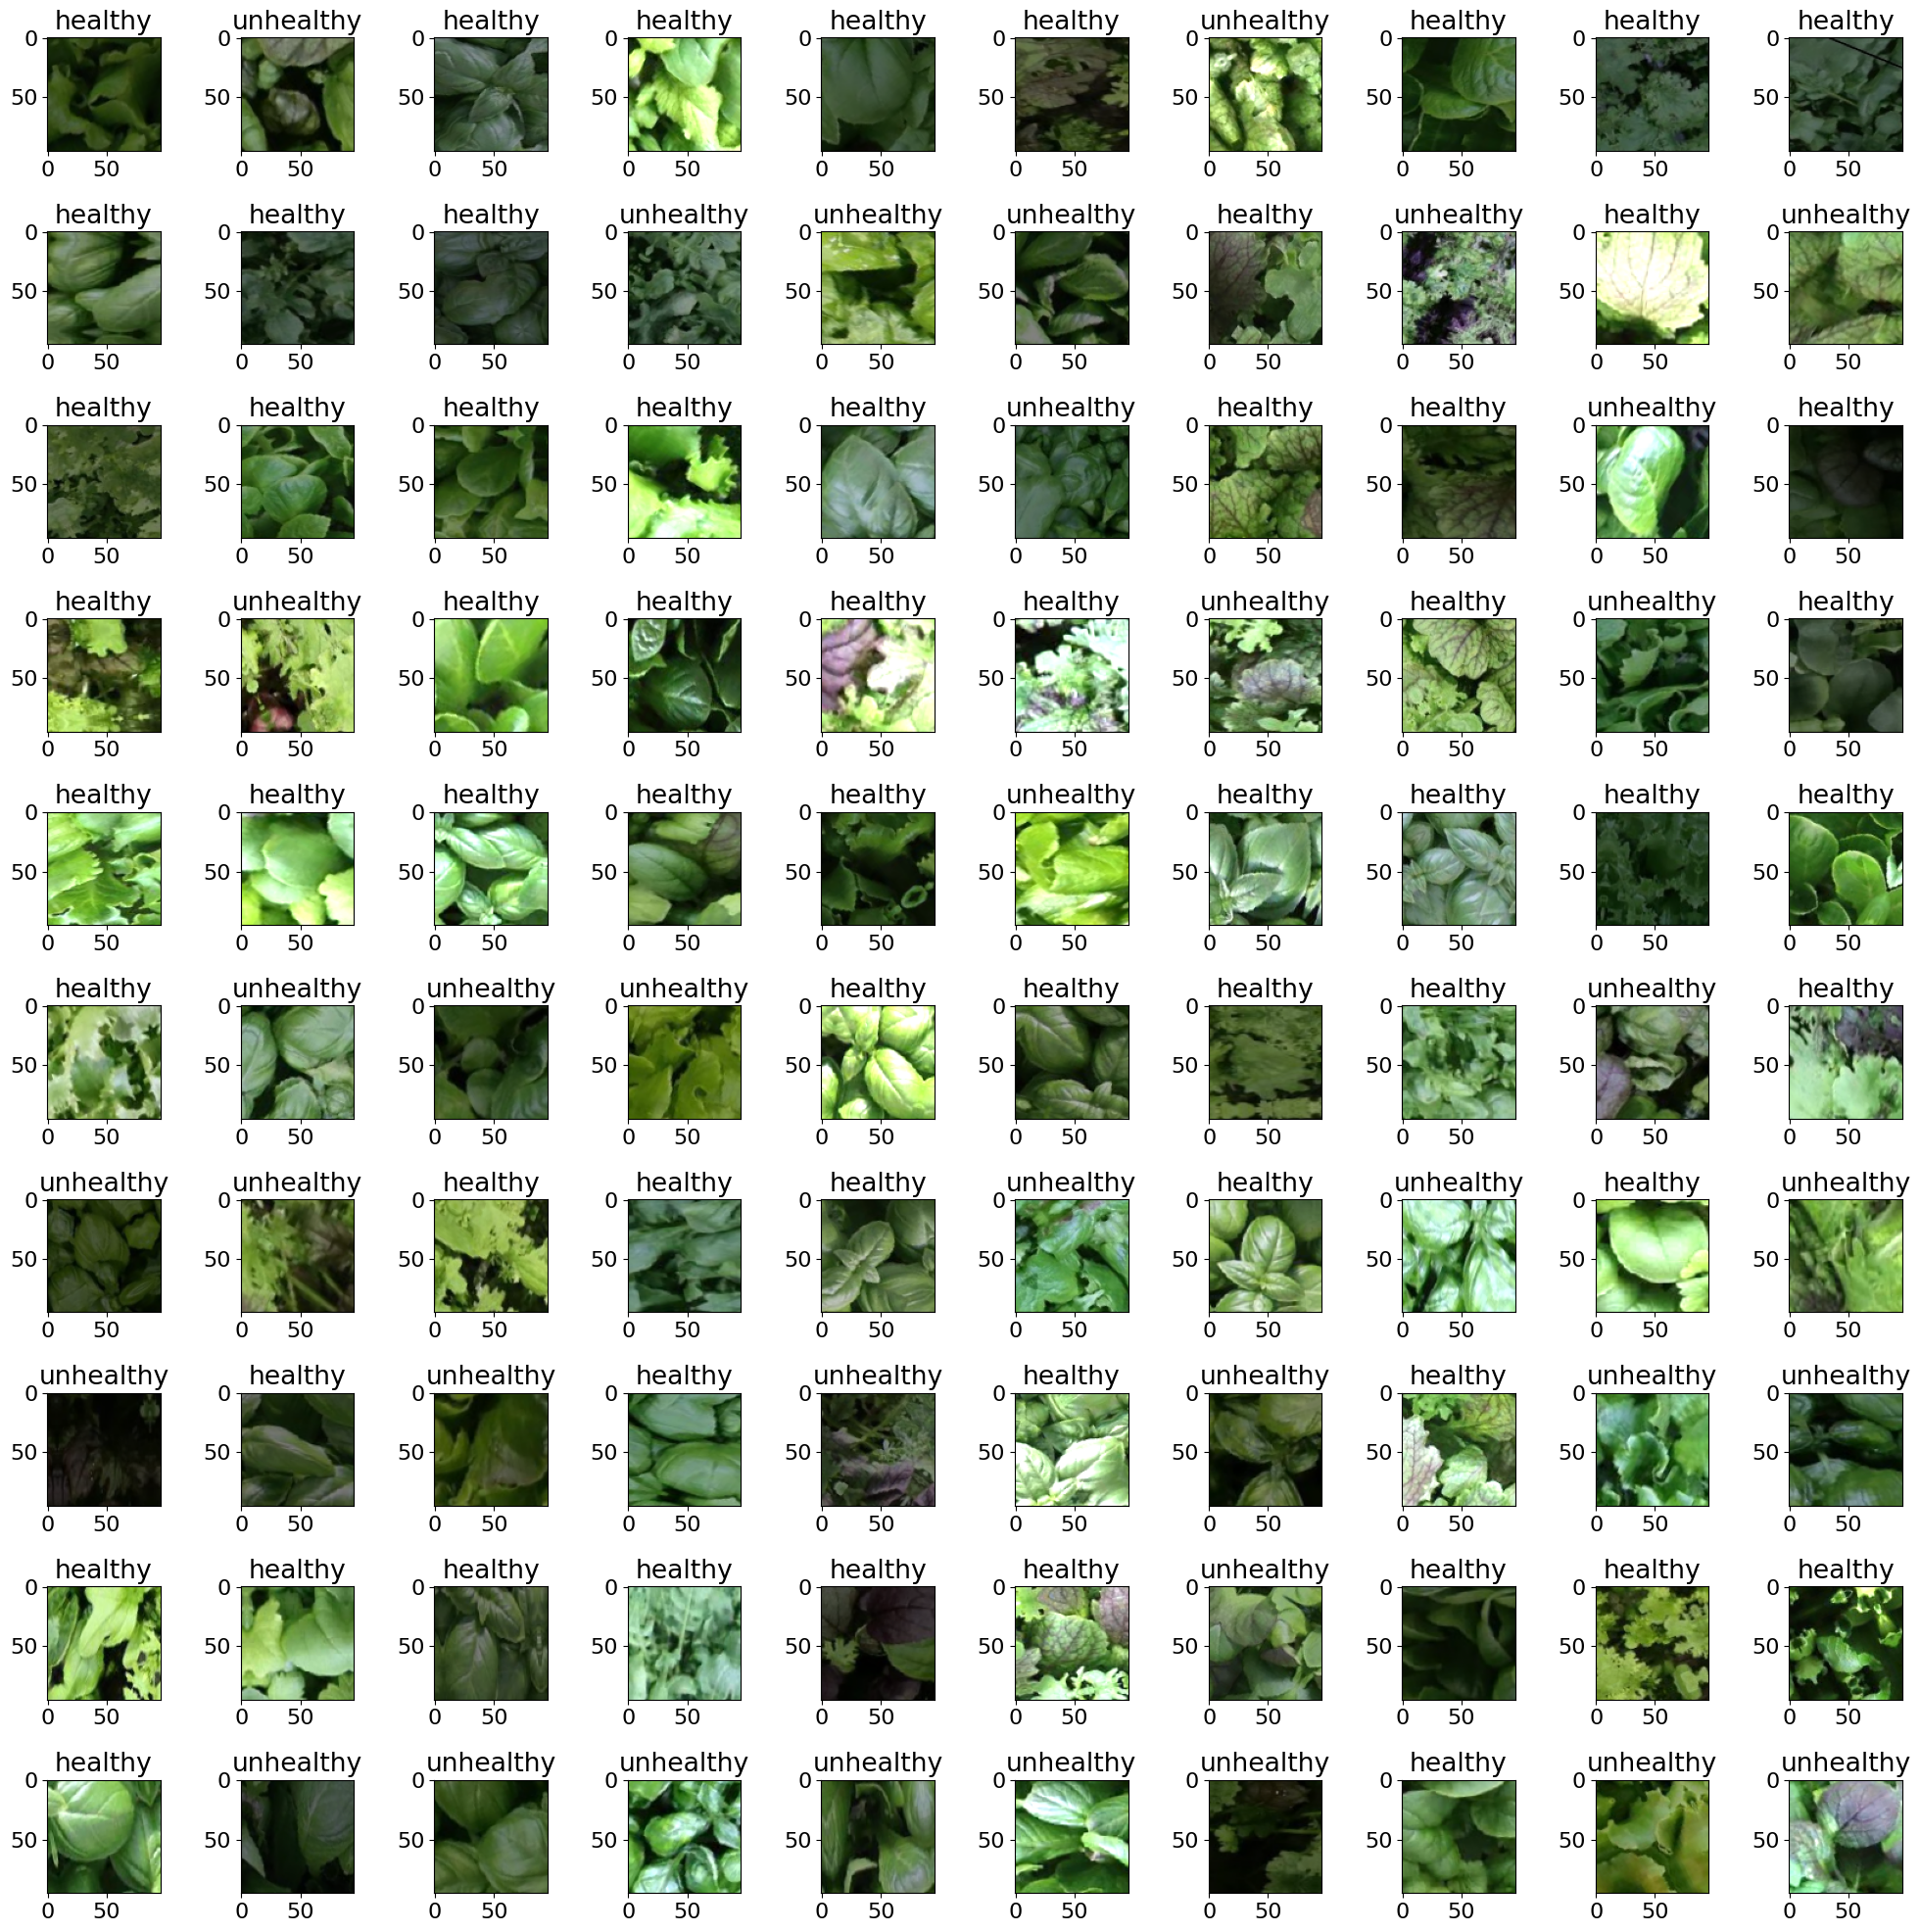

In [13]:
# Display a sample of images from the training-validation dataset
num_img = 100
num_rows = 10  # Number of rows (total images / 10 columns)
num_cols = 10  # Number of columns (10 images per row)

start = 0
end = 100

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Iterate through the selected number of images and print labels for debugging
for i in range(start, end):
    ax = axes[(i - start) // num_cols, (i - start) % num_cols]
    ax.imshow(augmented_images[i] / 255, cmap='gray')
    label = augmented_labels[i]
    ax.set_title('{}'.format(label))

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [14]:
# Print the shapes of the loaded datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)

print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (14610, 96, 96, 3)
Training Label Shape: (14610,)
Validation Data Shape: (7407, 96, 96, 3)
Validation Label Shape: (7407,)
Test Data Shape: (1001, 96, 96, 3)
Test Label Shape: (1001,)


In [15]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
healthy      9077
unhealthy    5533
Name: count, dtype: int64


In [17]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Encode labels in integers
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

In [18]:
patience = 30

early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, mode='auto')
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=patience, factor=0.999, mode='min', min_lr=1e-5)

# Define the model callbacks
callbacks = [
    early_stopping,
    lr_scheduler
]

In [19]:
# Define the supernetwork
supernet = tfk.applications.ConvNeXtLarge(
    model_name="convnext_large",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=(96, 96, 3)
)

supernet.trainable = False

In [20]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model
batch_size = 32                  # Batch size for training
epochs = 500                    # Number of training epochs

In [21]:
# hyperparameters
dropout_rate = 0.4
learning_rate = 1e-3

In [22]:

# Define the input layer with a specific shape and name
input_layer = tfkl.Input(shape=input_shape, name='Input')

# Pass the input through the supernet
x = supernet(input_layer)

# Flatten the output
x = Flatten(name='Flattening')(x)

# Apply dropout to the flattened output
x = tfkl.Dropout(dropout_rate)(x)

# Dense layer with 512 units and ReLU activation
x = tfkl.Dense(
    units=512,
    activation='relu',
    name='dense1'
)(x)

# Batch normalization layer
x = tfkl.BatchNormalization()(x)

# Apply dropout to the output of the first dense layer
x = tfkl.Dropout(dropout_rate)(x)

# Dense layer with 256 units and ReLU activation
x = tfkl.Dense(
    units=256,
    activation='relu',
    name='dense2'
)(x)

# Batch normalization layer
x = tfkl.BatchNormalization()(x)

# Apply dropout to the output of the second dense layer
x = tfkl.Dropout(dropout_rate)(x)

# Output layer with 2 units and softmax activation for binary classification
output_layer = tfkl.Dense(units=2, activation='softmax', name='Output')(x)

# Create the model with input and output layers
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

# Define the AdamW optimizer with a specified learning rate
opt = tfk.optimizers.AdamW(learning_rate)

# Define binary crossentropy as the loss function
loss = tfk.losses.BinaryCrossentropy()

# Specify accuracy as the evaluation metric
mtr = ['accuracy']

# Compile the model with the chosen optimizer, loss, and metrics
model.compile(loss=loss, optimizer=opt, metrics=mtr)

In [23]:
# Creating a dictionary containing class weights, to solve the problem of the data being unbalanced
from sklearn.utils import class_weight
import numpy as np

# Convert one-hot encoded labels to integer labels
y_integers = np.argmax(y_train, axis=1)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)

# Create a dictionary of class weights
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.8047813154125812, 1: 1.3202602566419663}


In [24]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weights,  # using the class weights during the training to give more power to the images unhealthy
    callbacks=callbacks
).history

Epoch 1/500
457/457 [==============================] - 80s 151ms/step - loss: 0.5008 - accuracy: 0.7832 - val_loss: 0.2784 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 2/500
457/457 [==============================] - 60s 132ms/step - loss: 0.3443 - accuracy: 0.8533 - val_loss: 0.2523 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 3/500
457/457 [==============================] - 60s 132ms/step - loss: 0.3007 - accuracy: 0.8745 - val_loss: 0.2209 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 4/500
457/457 [==============================] - 60s 131ms/step - loss: 0.2657 - accuracy: 0.8890 - val_loss: 0.2153 - val_accuracy: 0.9079 - lr: 0.0010
Epoch 5/500
457/457 [==============================] - 59s 130ms/step - loss: 0.2413 - accuracy: 0.8990 - val_loss: 0.2106 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 6/500
457/457 [==============================] - 59s 129ms/step - loss: 0.2209 - accuracy: 0.9101 - val_loss: 0.1883 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 7/500
457/457 [=========================

In [25]:
# Save the trained model
model.save('model')

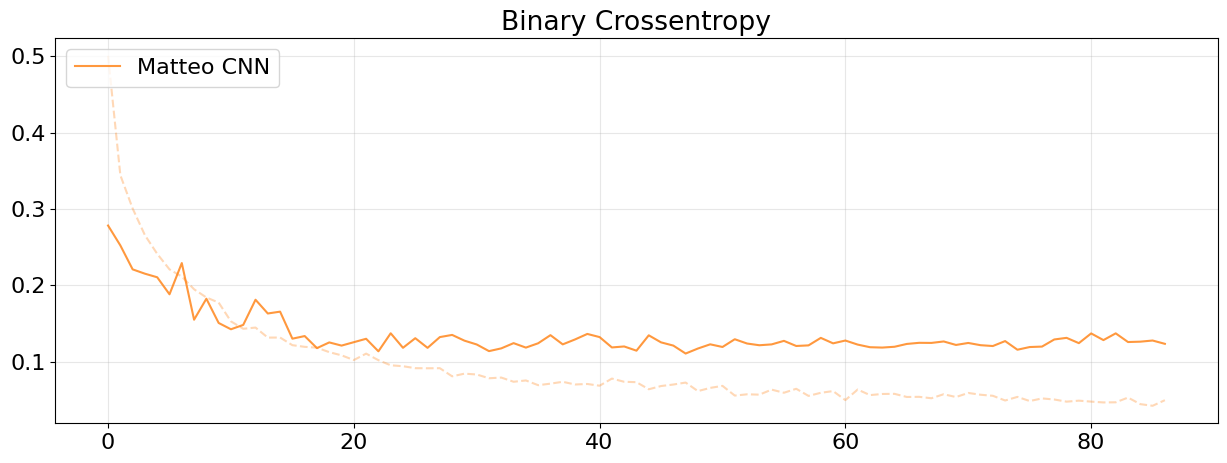

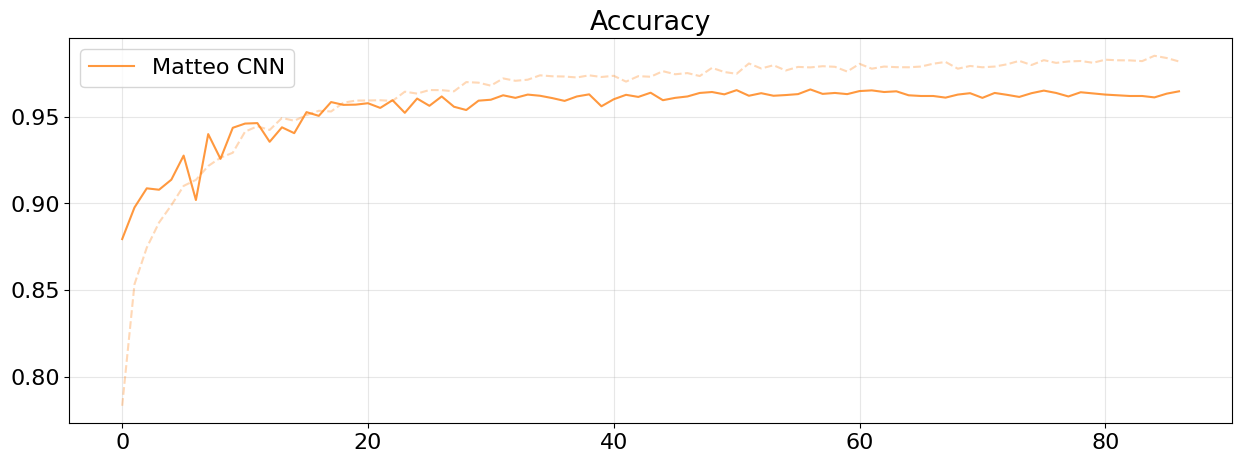

In [26]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Matteo CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Matteo CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [27]:
del model

In [28]:
model = tfk.models.load_model('model')
# model.summary()

Input image


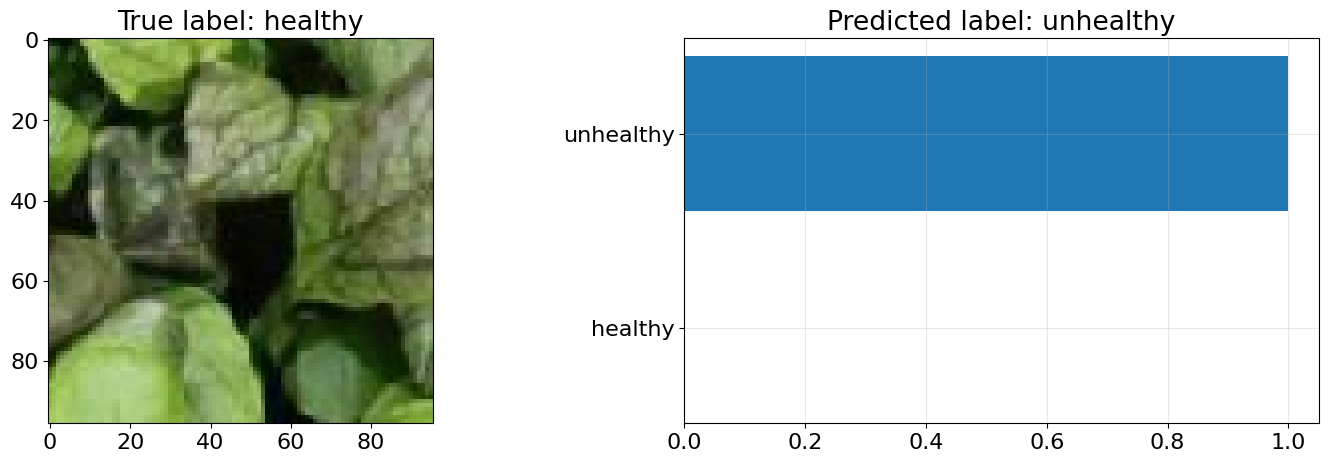

: 

In [52]:
# Choose a random image for visualization
image = np.random.randint(0, X_test.shape[0])

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)

image_to_show = (X_test[image] / 255).astype('float32')

ax1.imshow(image_to_show)
ax1.set_title('True label: ' + labels_array[np.argmax(y_test[image])])  # Access the label directly

prediction = model.predict(np.expand_dims(X_test[image], axis=0), verbose=0)

# Create a list of class labels for barh
class_labels = list(set(labels_array))  # Assuming you have unique class labels

ax2.barh(class_labels, np.squeeze(prediction), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + class_labels[np.argmax(prediction)])  # Use the predicted class label
ax2.grid(alpha=0.3)
plt.show()

In [30]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1001, 2)


Accuracy: 0.999
Precision: 0.9992
Recall: 0.9987
F1: 0.999


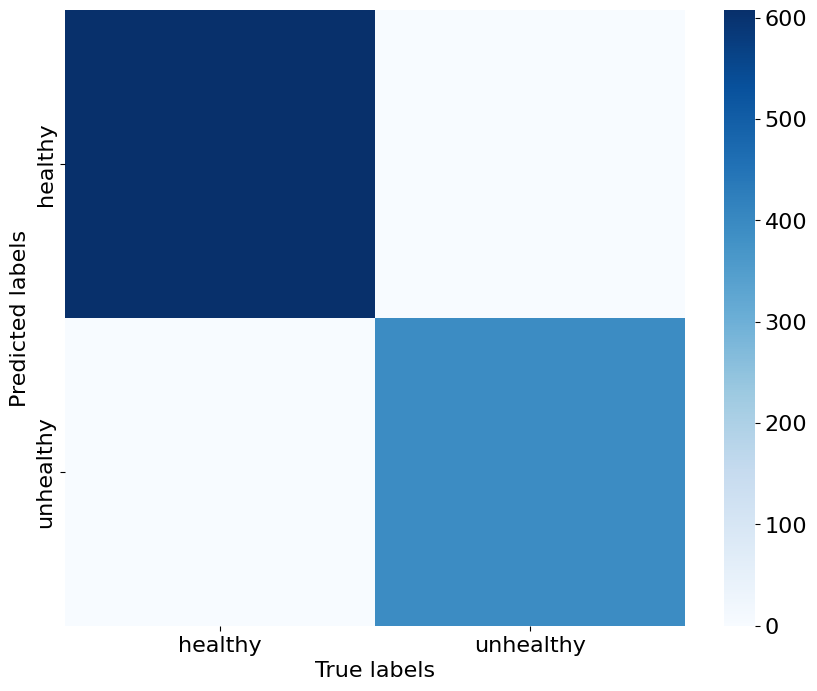

In [31]:
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# import the model for the fine tuning

model = tfk.models.load_model('model')
# low learning rate for fine tuning
learning_rate = 1e-5

# Set all MobileNetV2 layers as trainable
model.get_layer('convnext_large').trainable = True
for i, layer in enumerate(model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)

# Freeze first N layers, e.g., until the 133rd one
N = 160
for i, layer in enumerate(model.get_layer('convnext_large').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)


opt = tfk.optimizers.AdamW(learning_rate)
loss = tfk.losses.BinaryCrossentropy()
mtr = ['accuracy']
model.compile(loss=loss, optimizer=opt, metrics=mtr)

model.summary(expand_nested = True)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val,y_val),
    class_weight=class_weights,  #using the class weights during the training to give more power to the images unhealthy
    callbacks=callbacks
).history

model.save('cnl_da_fn')